In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install netCDF4

In [3]:
import os
import sys
DRIVE_ROOT = "/content/drive/MyDrive/DynamicsTensors"
REPO_ROOT  = f"{DRIVE_ROOT}/bstt2"
DATA_DIR   = f"{DRIVE_ROOT}/data"
OUT_DIR    = f"{DRIVE_ROOT}/outputs"

EXP = "basetests"
RUN_DIR = f"{OUT_DIR}/{EXP}"

os.makedirs(RUN_DIR, exist_ok=True)
if REPO_ROOT not in sys.path: sys.path.append(REPO_ROOT)

print("Repo:", REPO_ROOT)
print("Data:", DATA_DIR)
print("Run dir:", RUN_DIR)
train_path = os.path.join(DATA_DIR, "train_data.e")
test_path  = os.path.join(DATA_DIR, "test_data_2.e")

from utils import name_scan, inspect_fields, load_fields, Dataset, chartostring, plot_flow_snapshot, plot_heatmap_contours

Repo: /content/drive/MyDrive/DynamicsTensors/bstt2
Data: /content/drive/MyDrive/DynamicsTensors/data
Run dir: /content/drive/MyDrive/DynamicsTensors/outputs/basetests


In [4]:
# Uploading orginal bsst modules
from misc import  __block, sinecosine_measures, random_homogenous_polynomial_sum_system2,random_fixed_variable_sum_system2,legendre_measures
from helpers import fermi_pasta_ulam,fermi_pasta_ulam2,SMat
from als import ALSSystem2
from bstt import Block, BlockSparseTensor, BlockSparseTT
block = __block()
######################
# Import Standard libs
from time import time as clock
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.tri as mtri
from utils import name_scan, inspect_fields, load_fields, Dataset, chartostring, plot_flow_snapshot, plot_heatmap_contours


In [5]:
train_path = os.path.join(DATA_DIR, "train_data.e")
test_path  = os.path.join(DATA_DIR, "test_data_2.e")
print("format:", name_scan(train_path))
seed_global= 123
###################################################
meta = inspect_fields(train_path)
print(meta)
times, coordx, coordy, Vx, Vy, P, V_stack = load_fields(train_path, t_start=0, t_count=None)
# Randomization:
N_nodes = coordx.shape[0]
d_c     = 600
rng = np.random.default_rng(seed_global)
idx = rng.choice(N_nodes, size=d_c, replace=False)
idx.sort()


coordx = coordx[idx]
coordy = coordy[idx]
vx = Vx[idx, 0:5000]
vy = Vy[idx, 0:5000]
v_stack = np.vstack([vx, vy])

Vx_test = Vx[idx, 5000:]
Vy_test = Vy[idx, 5000:]
v_stack_test = np.vstack([Vx_test, Vy_test])


dv_stack = np.diff(v_stack, axis = 1)
dv_x = dv_stack[0:vx.shape[0],:]
dv_y = dv_stack[vx.shape[0] :,:]


print("shape times:", times.shape)
print("shape coords:", coordx.shape, coordy.shape)
print("shape Vx/Vy/P:", vx.shape, vy.shape, P.shape)
print("shape V_stack:", v_stack.shape)

format: exodus
{'format': 'exodus', 'num_nodes': 6569, 'num_elems': 6384, 'time_steps': 5541, 'nodal_var_names': ['V_y', 'V_x', 'P'], 'time_key_guess': 'time_whole'}
shape times: (5541,)
shape coords: (600,) (600,)
shape Vx/Vy/P: (600, 5000) (600, 5000) (6569, 5541)
shape V_stack: (1200, 5000)


In [6]:
# # Velocities vector fields extracted, data is stucked in V = [Vx,Vy,T].
# # Culculating difference ( extremely simple)

# # Test Data:
# times_t, x_t, y_t, Vx_t, Vy_t, P_t, V_stack_t = load_fields(test_path, t_start=0, t_count=5541)
# print(times_t.shape, Vx_t.shape, Vy_t.shape, P_t.shape, V_stack_t.shape)
# stride = 10
# idx = np.arange(0, coordx.shape[0], stride)
# x_t = x_t[idx]
# y_t = y_t[idx]
# Vx_t = Vx_t[idx, :]
# Vy_t = Vy_t[idx, :]
# V_stack_t = np.vstack([Vx_t, Vy_t])



# dV_stack_t= np.diff(V_stack_t, axis = 1)
# dV_x_t = dV_stack_t[0:Vx_t.shape[0],:]
# dV_y_t = dV_stack_t[Vx_t.shape[0] : Vx_t.shape[0] + Vy_t.shape[0],:]

# print("shape times:", times.shape)
# print("shape coords:", x_t.shape, y_t.shape)
# print("shape Vx/Vy/P:", Vx_t.shape, Vy_t.shape, P.shape)
# print("shape V_stack:", V_stack_t.shape)

In [7]:
def plot_vector_field(
    Fx,
    Fy,
    x,
    y,
    path,
    t_index=0,
    quiver_frac=0.03,
    probe_node=None,
    use_file_connectivity=True,
):
    """
    Plot a 2D vector field on an unstructured mesh.

    Parameters
    ----------
    Fx, Fy : (N_nodes, T)
        Components of the field (e.g. Vx, Vy) on nodes over time.
    x, y   : (N_nodes,)
        Node coordinates. Can be full or coarse-grained.
    path   : str
        Path to Exodus-II file (used to read connectivity if possible).
    t_index : int
        Time index to plot.
    quiver_frac : float
        Approximate fraction of nodes to use for quiver arrows (e.g. 0.03 -> ~3%).
    probe_node : int or None
        If not None, highlight this node index.
    use_file_connectivity : bool
        If True, try to use Exodus connectivity; if it doesn't match x,y size,
        fall back to Delaunay triangulation.
    """

    Fx = np.asarray(Fx)
    Fy = np.asarray(Fy)
    x = np.asarray(x)
    y = np.asarray(y)

    assert Fx.shape == Fy.shape, "Fx and Fy must have same shape (N_nodes, T)"
    assert x.shape == y.shape, "x and y must have same shape (N_nodes,)"

    N_nodes, T = Fx.shape
    assert 0 <= t_index < T, f"t_index={t_index} out of range [0, {T-1}]"

    # --- Build triangulation ---
    tri = None
    if use_file_connectivity:
        try:
            ds = Dataset(path, "r")
            conn_keys = [k for k in ds.variables.keys() if k.startswith("connect")]
            if not conn_keys:
                raise RuntimeError("No connectivity array ('connect*') found in file.")
            conn = np.asarray(ds.variables[conn_keys[0]][:], dtype=int) - 1

            # handle tri/quad elements
            if conn.shape[1] == 3:
                conn_full = conn
            elif conn.shape[1] == 4:
                conn_full = np.vstack([
                    conn[:, [0, 1, 2]],
                    conn[:, [0, 2, 3]],
                ])
            else:
                raise RuntimeError(
                    f"Unsupported element with {conn.shape[1]} nodes (expected 3 or 4)"
                )

            # if connectivity refers to indices >= N_nodes, we can't use it with current x,y
            if conn_full.max() >= N_nodes:
                # we already coarse-grained, so use Delaunay instead
                raise RuntimeError("Connectivity index exceeds x,y size; using Delaunay.")

            tri = mtri.Triangulation(x, y, triangles=conn_full)
        except Exception as e:
            # Fallback: Delaunay triangulation from x,y only
            # (fine for visualization, not for exact FEM topology)
            # print(f"Falling back to Delaunay triangulation: {e}")
            tri = mtri.Triangulation(x, y)
    else:
        tri = mtri.Triangulation(x, y)

    # --- Snapshot ---
    Vx_t = Fx[:, t_index]
    Vy_t = Fy[:, t_index]
    magnitude = np.sqrt(Vx_t**2 + Vy_t**2)

    # --- Downsample quiver points ---
    n = x.size
    step = max(1, int(round(1.0 / max(quiver_frac, 1e-6))))
    q_idx = np.arange(0, n, step)

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(15, 10))

    # scalar field |F|
    tpc = ax.tripcolor(tri, magnitude, shading="gouraud")
    plt.colorbar(tpc, ax=ax, shrink=0.9, label="|F|")

    # vector field
    ax.quiver(
        x[q_idx], y[q_idx], Vx_t[q_idx], Vy_t[q_idx],
        angles="xy", scale_units="xy", scale=1, width=0.002,
        alpha=0.9, zorder=3
    )

    # optional probe highlight
    if probe_node is not None and 0 <= probe_node < N_nodes:
        ax.scatter(x[probe_node], y[probe_node],
                   c="red", s=60, zorder=4, label=f"node {probe_node}")
        ax.legend(loc="best")

    ax.set_aspect("equal", adjustable="box")
    ax.set_title(f"{os.path.basename(path)} | t={t_index}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.tight_layout()
    plt.show()


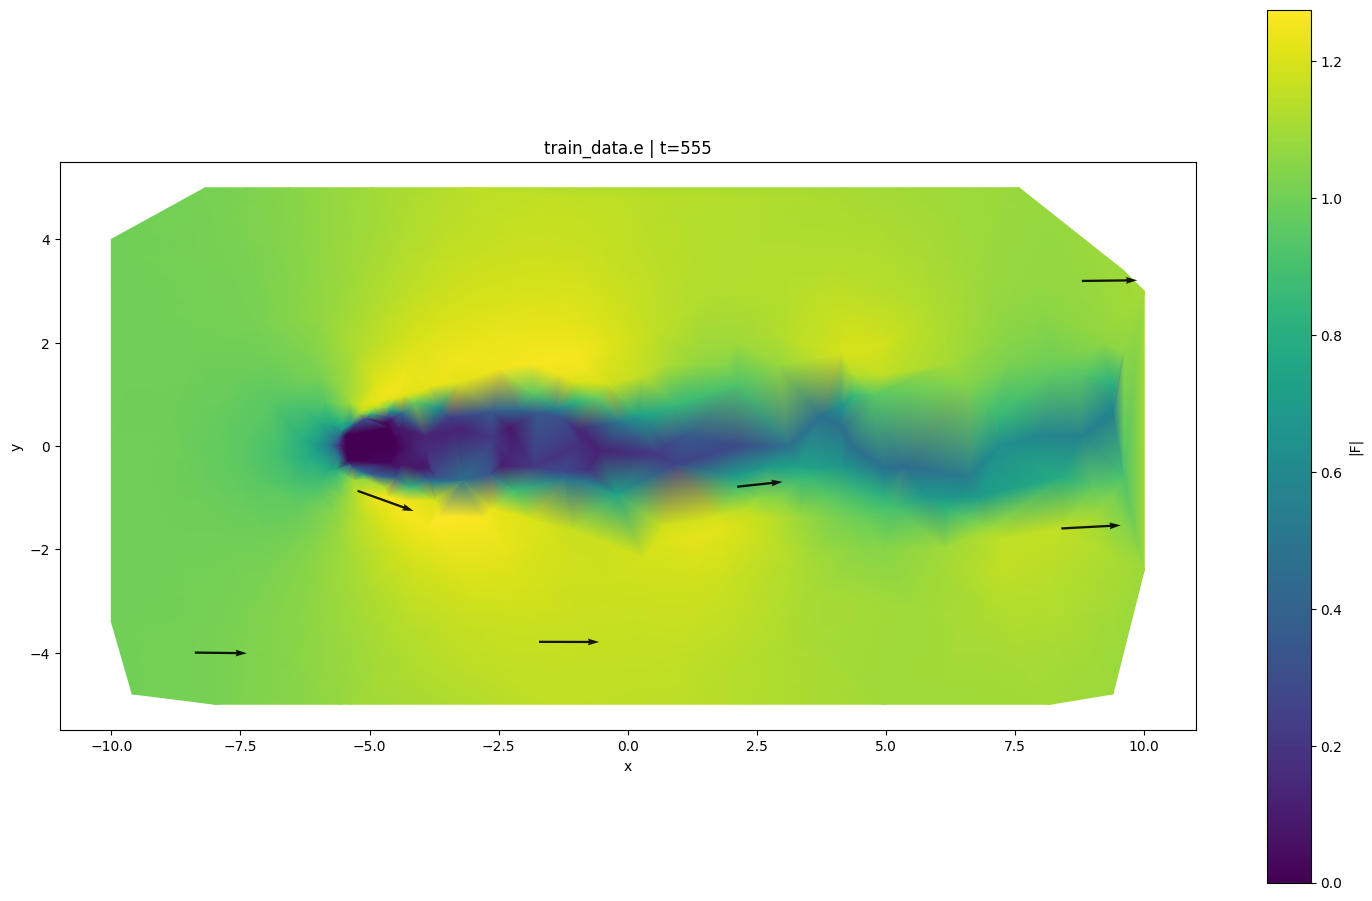

In [8]:
plot_vector_field(vx,vy,coordx,coordy,train_path, t_index=555, quiver_frac=0.01,use_file_connectivity=False)

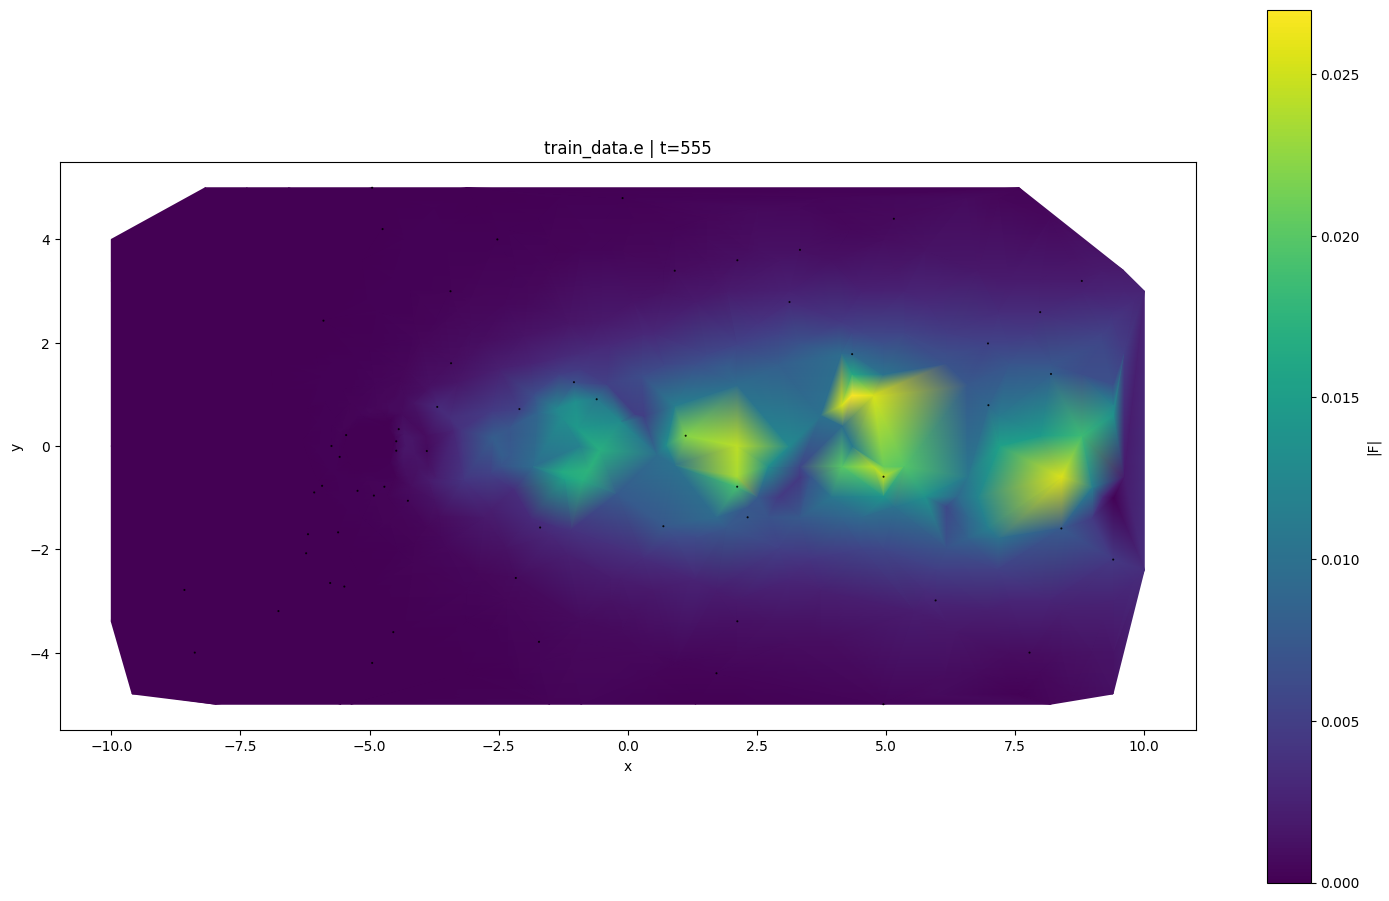

In [9]:
plot_vector_field(dv_x,dv_y,coordx,coordy, train_path, t_index=555,  quiver_frac=0.1)

### Dynmaics Extraction via BlockSparseTT

In [10]:
v_stack.shape

(1400, 5000)

In [10]:
# CONFIGURATION:
order =  1400
degree = 3  # [p0,p1,p2,p3...] - degree of funciton from dictionary
maxGroupSize = 1
interaction = 3
#interaction = [2]*order
trainSampleSize = [1000]
maxSweeps=5
ranks = [2]*(order-1)
targetResidual = 1e-6
testSampleSize = 400
seed_global = 123
###############################################################################

In [11]:
def build_measures(points, degree, add_constant_mode=True):
    """
    Build Legendre dict values per coordinate and optionally append a constant mode.
    points: (N, order)
    Returns:
        measures: (order + add_constant, N, degree+1)
    """
    # legendre_measures expects shape (N, M) and returns (M, N, degree+1)
    measures = legendre_measures(points, degree)  # (order, N, degree+1)
    if add_constant_mode:
        ones_row = np.ones((1, points.shape[0], degree + 1))
        measures = np.concatenate([measures, ones_row], axis=0)  # (order+1, N, degree+1)
    return measures


In [12]:
# measures = build_measures(V_stack, degree = degree)
# measures.shape
# del measures

In [13]:
def build_measures(points, degree):
    """
    Build Legendre dict values per coordinate and optionally append a constant mode.
    points: (N, order)
    Returns:
        measures: (order + add_constant, N, degree+1)
    """
    measures = legendre_measures(points, degree)
    return measures


def build_model(order, degree, maxGroupSize, interaction, selection_matrix=None):
    """
    Create a BlockSparseTTSystem2 model with degree-banded blocks and interaction gating.
    System2 expects an integer selection matrix of shape (D, order) where
    D = number of equations (=order here) and 'order' is the number of TT cores
    (we use order+1 measures; the extra constant mode is handled by the TT builder)
    """
    S = selection_matrix if selection_matrix is not None else SMat(interaction, order)
    bstt = random_homogenous_polynomial_sum_system2(
        _univariateDegrees=[degree] * order,
        _totalDegree=degree,
        _maxGroupSize=maxGroupSize,
        _numberOfInteractions=interaction,
        _selectionMatrix=S,
    )
    return bstt


def fit_model(bstt, measures, targets, maxSweeps, targetResidual, maxGroupSize, verbosity=1):
    """
    Wrap ALSSystem2 with already-augmented measures.
    measures: (order+1, N_samples, degree+1)
    targets:  (N_samples, order)
    """
    solver = ALSSystem2(bstt, measures, targets, _verbosity=verbosity)
    solver.maxSweeps = maxSweeps
    solver.targetResidual = targetResidual
    solver.maxGroupSize = maxGroupSize
    solver.run()
    return bstt, solver
# Evaluation
def rel_L2(pred, truth):
    """Relative L2 error"""
    return np.linalg.norm(pred - truth) / np.linalg.norm(truth)
def evaluate_model(bstt, measures_train, y_train, measures_test, y_test):
    """
    Evaluate on train & test measures/targets.
    Returns (err_train, err_test)
    """
    ytr_hat = bstt.evaluate(measures_train)
    yte_hat = bstt.evaluate(measures_test)
    return rel_L2(ytr_hat, y_train), rel_L2(yte_hat, y_test)

def run_learning_curve(
    states_full,    # (N_total, order) = points
    derivs_full,    # (N_total, order) = values
    states_test,    # (N_test_total, order)
    derivs_test,    # (N_test_total, order)
    order,
    degree,
    maxGroupSize,
    interaction,
    trainSampleSizes,
    testSampleSize,
    maxSweeps,
    targetResidual,
    seed=123,
    verbose=1,
):
    results = []

    # select test set
    N_test = min(testSampleSize, states_test.shape[0])
    test_points  = states_test[:N_test, :]
    test_values  = derivs_test[:N_test, :]

    test_measures = build_measures(test_points, degree)   # (order, N_test, degree+1)
    augmented_test_measures = np.concatenate(
        [test_measures, np.ones((1, N_test, degree+1))],
        axis=0
    )

    for N_samples_train in trainSampleSizes:
        if verbose:
            print(f"\n=== Training with N={N_samples_train} samples ===")

        train_points = states_full[:N_samples_train, :]   # (N_train, order)
        train_values = derivs_full[:N_samples_train, :]   # (N_train, order)

        train_measures = build_measures(train_points, degree) # (order, N_train, degree+1)
        augmented_train_measures = np.concatenate(
            [train_measures, np.ones((1, N_samples_train, degree+1))],
            axis=0
        )

        # model
        S    = SMat(interaction, order)
        bstt = random_homogenous_polynomial_sum_system2(
            _univariateDegrees=[degree]*order,
            _totalDegree=degree,
            _maxGroupSize=maxGroupSize,
            _numberOfInteractions=interaction,
            _selectionMatrix=S,
        )

        if verbose:
            print(f"DOFS: {bstt.dofs()}")
            print(f"Ranks: {bstt.ranks}")
            print(f"Interaction: {bstt.interactions}")

        # train
        bstt, solver = fit_model(
            bstt,
            augmented_train_measures,
            train_values,
            maxSweeps=maxSweeps,
            targetResidual=targetResidual,
            maxGroupSize=maxGroupSize,
            verbosity=1 if verbose else 0,
        )

        # evaluate
        values_tr_hat = bstt.evaluate(augmented_train_measures)
        values_te_hat = bstt.evaluate(augmented_test_measures)

        err_tr = rel_L2(values_tr_hat, train_values)
        err_te = rel_L2(values_te_hat, test_values)

        if verbose:
            print(f"L2 (test): {err_te:.3e} | L2 (train): {err_tr:.3e}")

        results.append({
            "N": int(N_samples_train),
            "L2_train": float(err_tr),
            "L2_test": float(err_te),
            "DOFS": int(bstt.dofs()),
            "ranks": list(bstt.ranks),
            "interaction": int(bstt.interactions),
        })

    return results, bstt


In [ ]:
# V_stack: (d, T)
# V_stack_t: (d, T_test)
dt = times[1] - times[0]   # or 1.0 if you just care about relative errors


states_full  = v_stack.T[:-1, :]                       # (T-1, d)
derivs_full  = (v_stack.T[1:, :] - v_stack.T[:-1, :]) / dt   # (T-1, d)

states_test  = v_stack_test.T[:-1, :]                     # (T_test-1, d)
derivs_test  = (v_stack_test.T[1:, :] - v_stack_test.T[:-1, :]) / dt
order = states_full.shape[1]

N_total = states_full.shape[0]    # = T-1
N_train = 1000

rng = np.random.default_rng(seed_global)
train_idx = rng.choice(N_total, size=N_train, replace=False)
train_idx.sort()

train_points = states_full[train_idx, :]   # (500, order)
train_values = derivs_full[train_idx, :]   # (500, order)

N_test = 1000
all_idx = np.arange(N_total)
rng = np.random.default_rng(seed_global)
rng.shuffle(all_idx)

train_idx = all_idx[:N_train]
test_idx  = all_idx[N_train:N_train+N_test]
train_idx.sort()

test_points  = states_full[test_idx]
test_values  = derivs_full[test_idx]


results, trained_tensor = run_learning_curve(
    train_points, train_values,
    test_points, test_values,
    order=order,
    degree=degree,
    maxGroupSize=maxGroupSize,
    interaction=interaction,
    trainSampleSizes=trainSampleSize,
    testSampleSize=testSampleSize,
    maxSweeps=maxSweeps,
    targetResidual=targetResidual,
    seed=123,
    verbose=1,
)

print("\nN\tL2_train\tL2_test\tDOFS\tRanks")
for r in results:
    print(f"{r['N']}\t{r['L2_train']:.3e}\t{r['L2_test']:.3e}\t{r['DOFS']}\t{r['ranks']}")


=== Training with N=1000 samples ===
DOFS: 35994
Ranks: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

In [ ]:
np.savez(os.path.join(OUT_DIR + "results_cg.npz"), results=results)
np.savez(os.path.join(OUT_DIR + "trained_tensor_cg.npz"), trained_tensor=trained_tensor)

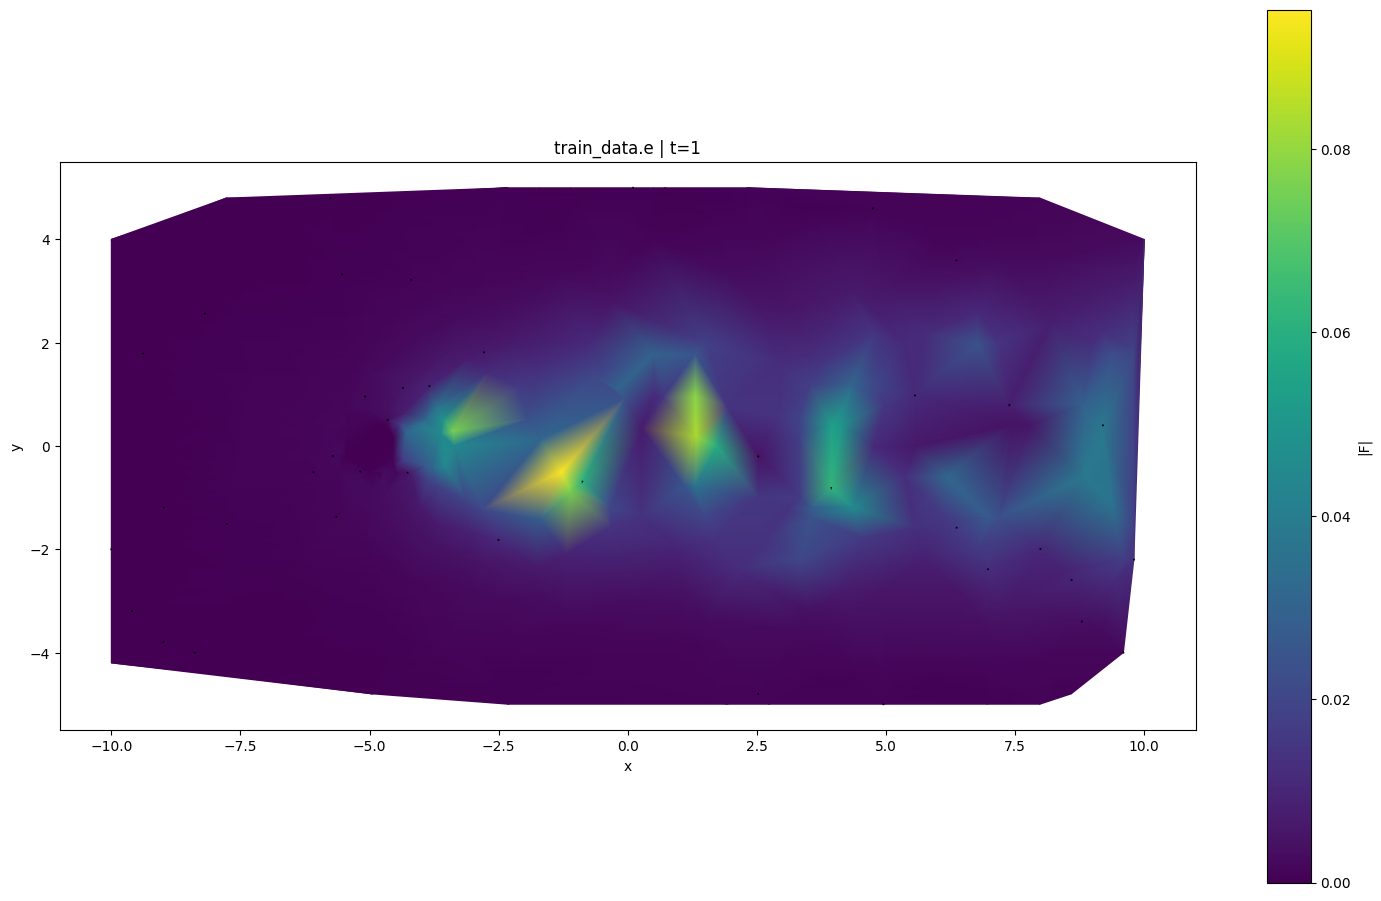

In [35]:

## Evaluation:
Vx_test = Vx[idx, 5000:]
Vy_test = Vy[idx, 5000:]
v_stack_test = np.vstack([Vx_test, Vy_test])
dv_x_test = Vx_test.T[1:, :] - Vx_test.T[:-1, :]
dv_y_test = Vy_test.T[1:, :] - Vy_test.T[:-1, :]
derivs_test = (v_stack_test.T[1:, :] - v_stack_test.T[:-1, :])

plot_vector_field(dv_x_test.T,dv_y_test.T,coordx,coordy, train_path, t_index=1,  quiver_frac=0.1)

In [51]:

testing_measures = build_measures(v_stack_test.T, degree = degree)
augmented_test_measures = np.concatenate(
        [testing_measures, np.ones((1, 541, degree+1))],
        axis=0
    )
res = trained_tensor.evaluate(augmented_test_measures)

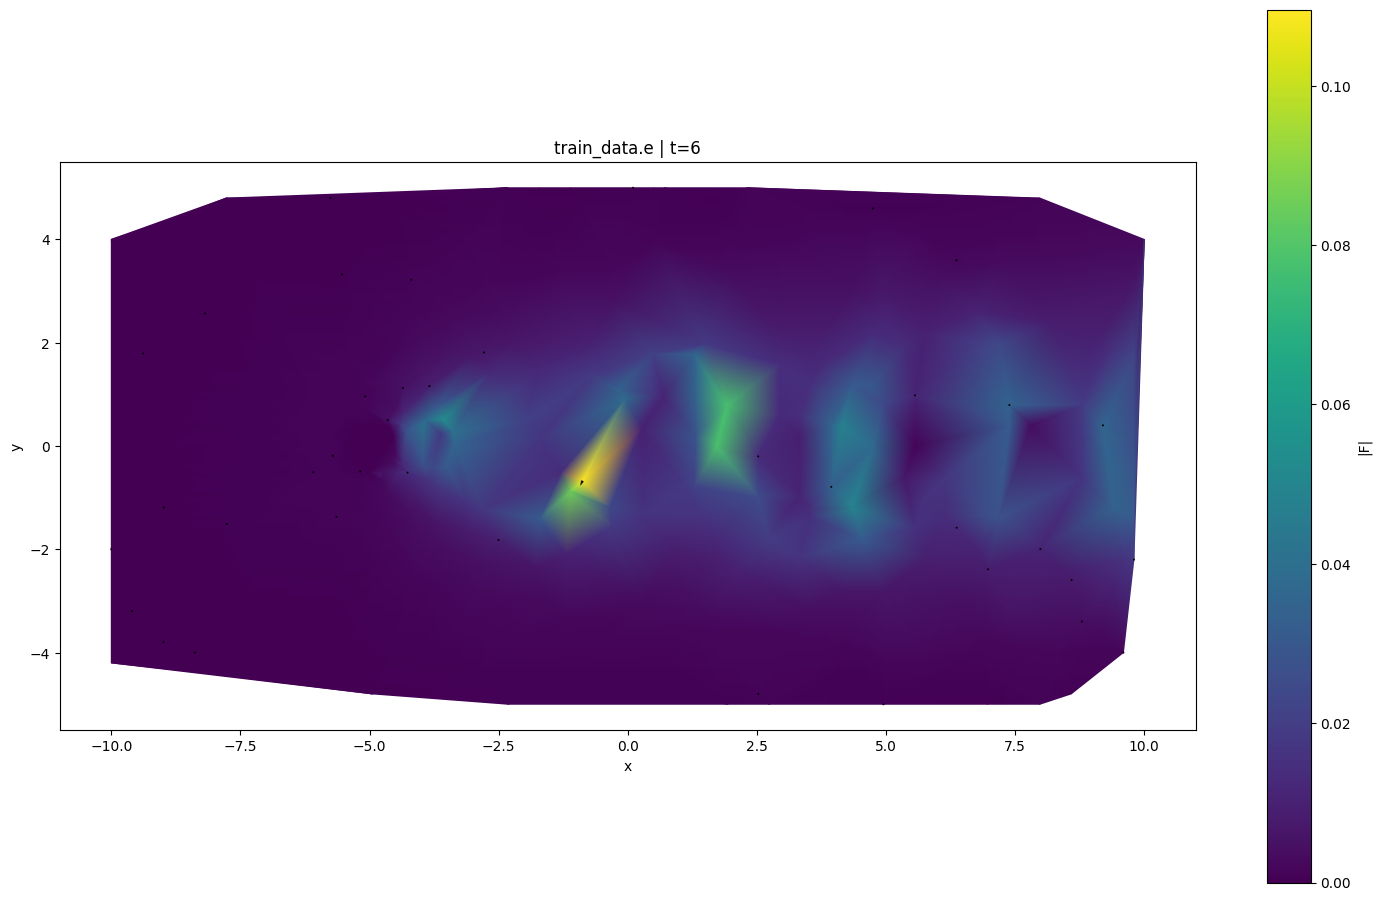

In [67]:
plot_vector_field(dv_x_test.T,dv_y_test.T,coordx,coordy, train_path, t_index=6,  quiver_frac=0.1)

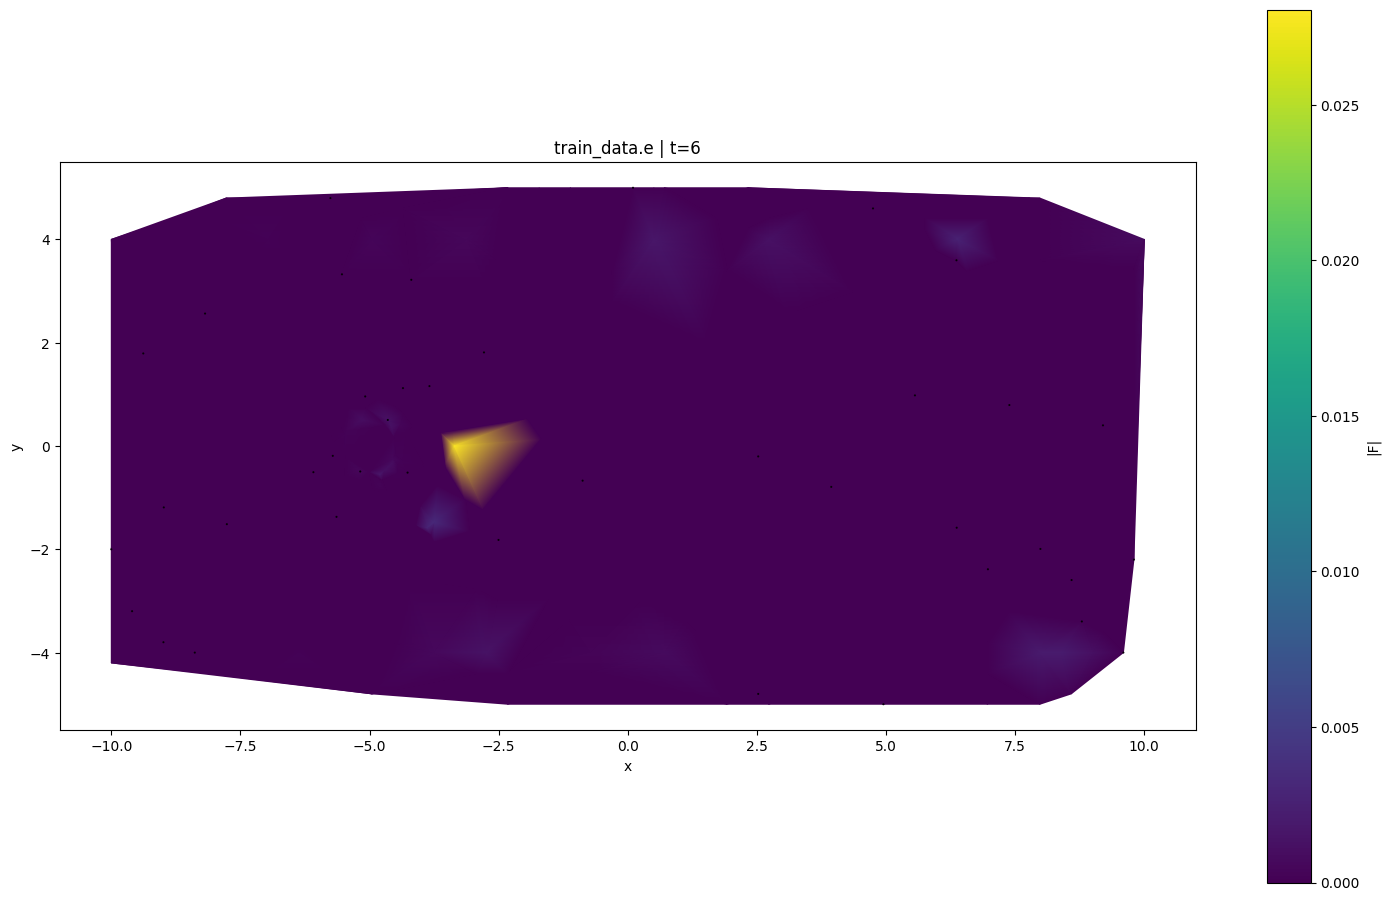

In [66]:
dv_stack_hat = res.T
dv_x_hat = dv_stack_hat[0:400,:]
dv_y_hat = dv_stack_hat[400:800,:]
plot_vector_field(dv_x_hat,dv_y_hat,coordx,coordy, train_path, t_index=6,  quiver_frac=0.1)